In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import ipywidgets as widgets
import math
from ipywidgets import interact
from scipy.sparse.linalg import lsqr
import scipy.sparse.linalg as spla

# Sample Search Crop

In [2]:
def sample_target(im, target_bb, search_area_factor = 5, output_sz=None):
    """
    Extracts a square crop centered at target_bb box, of area search_area_factor^2 times target_bb area.

    Args:
        im: cv image.
        target_bb: Target box [x, y, w, h].
        search_area_factor: Ratio of crop size to target size.
        output_sz (float): Size to which the extracted crop is resized (always square). If None, no resizing is done.

    Returns:
        cv image: Extracted crop.
        float: The factor by which the crop has been resized to make the crop size equal output_size.
    """

    if not isinstance(target_bb, list):
        x, y, w, h = target_bb.tolist()
    else:
        x, y, w, h = target_bb

    # Crop image
    crop_sz = math.ceil(math.sqrt(w * h) * search_area_factor)

    if crop_sz < 1:
        raise Exception('ERROR: too small bounding box')

    x1 = round(x + 0.5 * w - crop_sz * 0.5)
    x2 = x1 + crop_sz

    y1 = round(y + 0.5 * h - crop_sz * 0.5)
    y2 = y1 + crop_sz

    x1_pad = max(0, -x1)
    x2_pad = max(x2 - im.shape[1] + 1, 0)

    y1_pad = max(0, -y1)
    y2_pad = max(y2 - im.shape[0] + 1, 0)

    # Crop target
    im_crop = im[y1 + y1_pad:y2 - y2_pad, x1 + x1_pad:x2 - x2_pad, :]

    # Pad
    im_crop_padded = cv2.copyMakeBorder(im_crop, y1_pad, y2_pad, x1_pad, x2_pad, cv2.BORDER_CONSTANT)

    # Deal with attention mask
    H, W, _ = im_crop_padded.shape
    att_mask = np.ones((H, W))
    end_x, end_y = -x2_pad, -y2_pad
    if y2_pad == 0:
        end_y = None
    if x2_pad == 0:
        end_x = None
    att_mask[y1_pad:end_y, x1_pad:end_x] = 0

    if output_sz is not None:
        resize_factor = output_sz / crop_sz
        im_crop_padded = cv2.resize(im_crop_padded, (output_sz, output_sz))
        att_mask = cv2.resize(att_mask, (output_sz, output_sz)).astype(np.bool_)
        return im_crop_padded, resize_factor, att_mask
    else:
        return im_crop_padded, att_mask.astype(np.bool_), 1.0


# Tangential Projection

In [3]:
class SphereCoordinates(object):
    def __init__(self, kernel_size=3, sphereW=1280, sphereH=640, view_angle=65.5, imgW=640):
        '''
        Assume even -- sphereH / sphereW / imgW
        Assume odd -- kernel_size
        '''

        self.sphereW = sphereW
        self.sphereH = sphereH
        self.kernel_size = kernel_size
        self.shape = (kernel_size, kernel_size)

        TX, TY = self._meshgrid()
        kernel_angle = kernel_size * view_angle / imgW
        R, ANGy = self._compute_radius(kernel_angle, TY)

        self._R = R
        self._ANGy = ANGy
        self._Z = TX

    def _meshgrid(self):
        TX, TY = np.meshgrid(range(self.kernel_size), range(self.kernel_size))

        center = self.kernel_size / 2
        if self.kernel_size % 2 == 1:
            TX = TX.astype(np.float64) - center
            TY = TY.astype(np.float64) - center
        else:
            TX = TX.astype(np.float64) + 0.5 - center
            TY = TY.astype(np.float64) + 0.5 - center
        return TX, TY

    def _compute_radius(self, angle, TY):
        _angle = np.pi * angle / 180.
        r = self.kernel_size/2 / np.tan(_angle/2)
        R = np.sqrt(np.power(TY, 2) + r**2)
        ANGy = np.arctan(-TY/r)
        return R, ANGy

    def generate_grid(self, **kwargs):
        if "tilt" in kwargs:
            tilt = kwargs["tilt"]
            if not self.sphereH > tilt >= 0:
                raise ValueError("Invalid polar displace")
            rotate_y = (self.sphereH/2 - 0.5 - tilt) * np.pi / self.sphereH
            rotate_x = 0.
        else:
            rotate_x = 0.
            rotate_y = 0.
            if "rotate_x" in kwargs:
                rotate_x = kwargs["rotate_x"]
            if "rotate_y" in kwargs:
                rotate_y = kwargs["rotate_y"]
        angle_y, angle_x = self.direct_camera(rotate_y, rotate_x)
        Px, Py = self._sample_points(angle_y, angle_x)
        return Px, Py

    def _sample_points(self, angle_y, angle_x):
        # align center pixel with pixel on the image
        Px = (angle_x + np.pi) / (2*np.pi) * self.sphereW
        Py = (np.pi/2 - angle_y) / np.pi * self.sphereH - 0.5

        # Assume dead zone on the pole
        INDy = Py < 0
        Py[INDy] = 0
        INDy = Py > self.sphereH - 1
        Py[INDy] = self.sphereH - 1

        # check boundary, ensure interpolation
        INDx = Px < 0
        Px[INDx] += self.sphereW
        INDx = Px >= self.sphereW
        Px[INDx] -= self.sphereW
        return Px, Py

    def direct_camera(self, rotate_y, rotate_x):
        angle_y = self._ANGy + rotate_y
        INDn = np.abs(angle_y) > np.pi/2 # Padding great circle

        X = np.sin(angle_y) * self._R
        Y = - np.cos(angle_y) * self._R
        Z = self._Z

        angle_x = np.arctan(Z / -Y)
        # Padding great circle leads to unsymmetric receptive field
        # so pad with neighbor pixel
        angle_x[INDn] += np.pi
        angle_x += rotate_x
        RZY = np.linalg.norm(np.stack((Y, Z), axis=0), axis=0)
        angle_y = np.arctan(X / RZY)

        INDx = angle_x <= -np.pi
        angle_x[INDx] += 2*np.pi
        INDx = angle_x > np.pi
        angle_x[INDx] -= 2*np.pi
        return angle_y, angle_x


class SphereProjection(SphereCoordinates):
    def __init__(self, kernel_size=3, sphereW=640, sphereH=320, view_angle=65.5, imgW=640):
        super(SphereProjection, self).__init__(kernel_size, sphereW, sphereH, view_angle, imgW)

    def buildP(self, **kwargs):
        if "tilt" in kwargs:
            tilt = kwargs["tilt"]
            Px, Py = self.generate_grid(tilt=tilt)
        else:
            rotate_x = 0.
            rotate_y = 0.
            if "rotate_x" in kwargs:
                rotate_x = kwargs["rotate_x"]
            if "rotate_y" in kwargs:
                rotate_y = kwargs["rotate_y"]
            Px, Py = self.generate_grid(rotate_y=rotate_y, rotate_x=rotate_x)
        row = []
        col = []
        data = []
        for oy in range(Px.shape[0]):
            for ox in range(Px.shape[1]):
                ix = Px[oy, ox]
                iy = Py[oy, ox]
                c00, c01, c10, c11 = self._bilinear_coef(ix, iy)
                i00, i01, i10, i11 = self._bilinear_idx(ix, iy)
                oi = oy * Px.shape[1] + ox

                row.append(oi)
                col.append(i00)
                data.append(c00)

                row.append(oi)
                col.append(i01)
                data.append(c01)

                row.append(oi)
                col.append(i10)
                data.append(c10)

                row.append(oi)
                col.append(i11)
                data.append(c11)
        P = csr_matrix((data, (row, col)), shape=(Px.size, int(self.sphereH*self.sphereW)))
        return P

    def _bilinear_coef(self, ix, iy):
        ix0, ix1, iy0, iy1 = self._compute_coord(ix, iy)
        dx0 = ix - ix0
        dx1 = ix1 - ix
        dy0 = iy - iy0
        dy1 = iy1 - iy
        c00 = dx1 * dy1
        c01 = dx1 * dy0
        c10 = dx0 * dy1
        c11 = dx0 * dy0
        return c00, c01, c10, c11

    def _bilinear_idx(self, ix, iy):
        ix0, ix1, iy0, iy1 = self._compute_coord(ix, iy)
        if ix0 >= self.sphereW:
            ix0 = self.sphereW - 1
        if ix1 >= self.sphereW:
            ix1 = self.sphereW - 1
        if ix0 < 0:
            ix0 = 0
        if ix1 < 0:
            ix1 = 0

        if iy0 >= self.sphereH:
            iy0 = self.sphereH - 1
        if iy1 >= self.sphereH:
            iy1 = self.sphereH - 1
        if iy0 < 0:
            iy0 = 0
        if iy1 < 0:
            iy1 = 0

        i00 = iy0 * self.sphereW + ix0
        i10 = iy0 * self.sphereW + ix1
        i01 = iy1 * self.sphereW + ix0
        i11 = iy1 * self.sphereW + ix1
        return i00, i01, i10, i11

    def _compute_coord(self, ix, iy):
        if ix.is_integer():
            ix0 = int(ix)
            ix1 = ix0 + 1
        else:
            ix0 = int(np.floor(ix))
            ix1 = int(np.ceil(ix))
        if iy.is_integer():
            iy0 = int(iy)
            iy1 = iy0 + 1
        else:
            iy0 = int(np.floor(iy))
            iy1 = int(np.ceil(iy))
        return ix0, ix1, iy0, iy1

    def project(self, P, img):
        output = np.stack([P.dot(img[:,:,c].ravel()).reshape(self.shape) for c in range(3)], axis=2)
        return output

# Convert search crop to tangential search crop via Gnomonic Projection

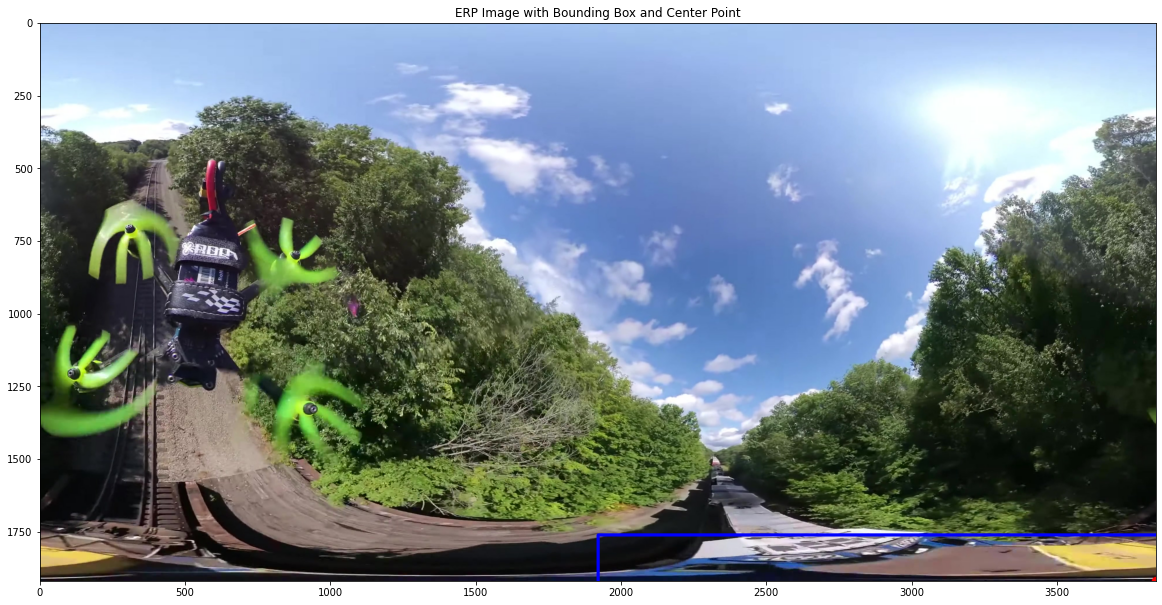

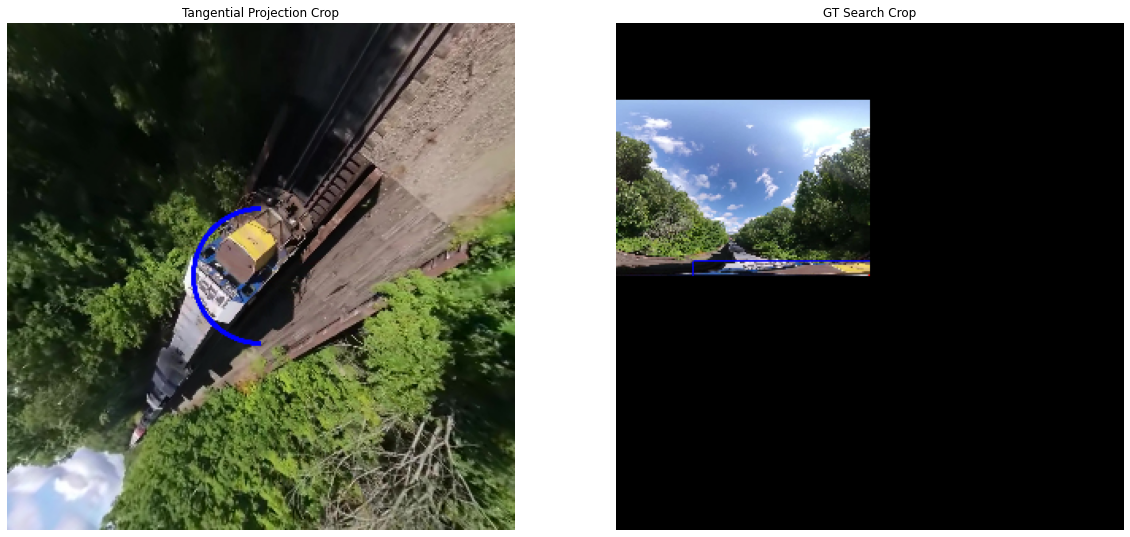

In [99]:
def calculate_bbox_center(bbox):
    x, y, w, h = bbox
    cx = x + w / 2
    cy = y + h / 2
    return int(cx), int(cy)

def calculate_projection_params(bbox, img_width, img_height):
    cx, cy = calculate_bbox_center(bbox)
    
    # Horizontal rotation (longitude)
    rotate_x = 360 * (cx / img_width) - 180  # Convert to degrees centered at 0
    
    # Vertical rotation (latitude)
    rotate_y = 90 - (cy / img_height) * 180  # Convert to degrees centered at 0

    return rotate_x, rotate_y

def get_projected_crop(erp_image, bbox, kernel_size=320, view_angle=90):
    img_height, img_width, _ = erp_image.shape
    
    # Calculate projection parameters
    rotate_x, rotate_y = calculate_projection_params(bbox, img_width, img_height)
    
    # Initialize the SphereProjection class
    projection = SphereProjection(kernel_size, img_width, img_height, view_angle, kernel_size)
    
    # Convert rotate_x and rotate_y from degrees to radians
    rotate_x_rad = np.deg2rad(rotate_x)
    rotate_y_rad = np.deg2rad(rotate_y)
    
    # Build the projection matrix
    P = projection.buildP(rotate_x=rotate_x_rad, rotate_y=rotate_y_rad)
    
    # Apply the projection to the ERP image
    projected_crop = projection.project(P, erp_image)
    
    return projected_crop, P, projection, rotate_x, rotate_y

# Bounding box coordinates (x, y, w, h)
bbox_coords = [1920.0, 1761.5, 3840, 317]
bbox_coords_two = [291.94444444444434, 1062.5, 35, 55]

# Load the ERP image using OpenCV
erp_image_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0115/image/000063.jpg'
erp_image_path_two = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0115/image/000153.jpg'
erp_image = cv2.imread(erp_image_path)
erp_image = cv2.cvtColor(erp_image, cv2.COLOR_BGR2RGB)

# Calculate the center point of the bounding box
point = calculate_bbox_center(bbox_coords)

# Draw a circle at the center point
cv2.circle(erp_image, point, 5, (255, 0 , 0), 20)

# Draw the bounding box on the image
x, y, w, h = map(int, bbox_coords)
cv2.rectangle(erp_image, (x, y), (x + w, y + h), (0, 0, 255), 10)

# Get the projected crop around the bounding box
projected_crop, P, projection, rotate_x, rotate_y = get_projected_crop(erp_image, bbox_coords)

# Get Search crop around the ERP
search_crop, _, _ = sample_target(erp_image, bbox_coords, output_sz=320)

# Display the ERP image with the bounding box and center point
plt.figure(figsize=(20, 20))
plt.imshow(erp_image)
plt.title('ERP Image with Bounding Box and Center Point')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the projected crop
axes[0].imshow(projected_crop.astype(np.uint8))
axes[0].set_title('Tangential Projection Crop')
axes[0].axis('off')

# Display the search crop
axes[1].imshow(search_crop)
axes[1].set_title('GT Search Crop')
axes[1].axis('off')

plt.show()

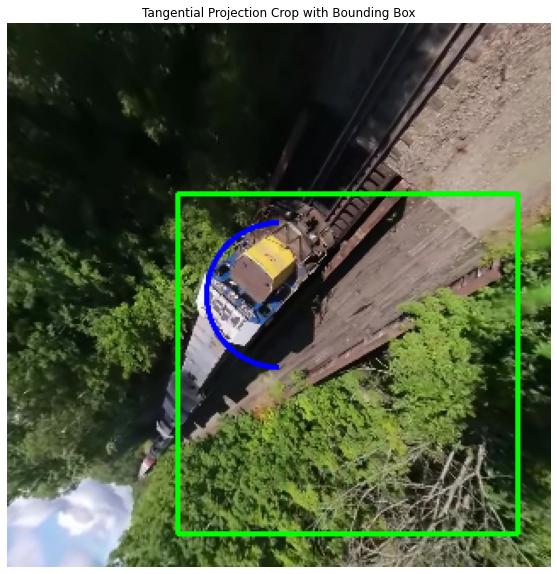

In [100]:
# Function to draw bounding box on the image
def draw_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    x, y, w, h = map(int, bbox)
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), color, thickness)
    return image_with_bbox

# Example bounding box coordinates detected in the Tangential Projection Crop
tangential_bbox = [100, 100, 200, 200]  # Example coordinates (x, y, w, h)

# Draw the bounding box on the Tangential Projection Crop
projected_crop_with_bbox = draw_bbox(projected_crop.astype(np.uint8), tangential_bbox, color=(0, 255, 0), thickness=2)

# Display the Tangential Projection Crop with the bounding box
plt.figure(figsize=(10, 10))
plt.imshow(projected_crop_with_bbox)
plt.title('Tangential Projection Crop with Bounding Box')
plt.axis('off')
plt.show()

In [ ]:
# Load the ERP image using OpenCV
erp_image = cv2.imread('/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0052/image/000003.jpg')
erp_image = cv2.cvtColor(erp_image, cv2.COLOR_BGR2RGB)



# Determine the dimensions of the ERP image
sphereH, sphereW, _ = erp_image.shape
imgW = 320

def update_projection(kernel_size=10, tilt=0, rotate_x=0, rotate_y=0, view_angle=90):
    print(f"Updating projection with kernel_size={kernel_size}, tilt={tilt}, rotate_x={rotate_x}, rotate_y={rotate_y}, view_angle={view_angle}")
    projection = SphereProjection(kernel_size, sphereW, sphereH, view_angle, imgW)
    
    # Convert rotate_x and rotate_y from degrees to radians
    rotate_x_rad = np.deg2rad(rotate_x)
    rotate_y_rad = np.deg2rad(rotate_y)
    
    # Generate grid with rotation
    Px, Py = projection.generate_grid(rotate_x=rotate_x_rad, rotate_y=rotate_y_rad)

    # Build the projection matrix
    P = projection.buildP(rotate_x=rotate_x_rad, rotate_y=rotate_y_rad)

    # Apply the projection to the ERP image
    output_image = projection.project(P, erp_image)

    # Display the output image
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image.astype(np.uint8))
    plt.show()

# Create interactive widgets
kernel_size_slider = widgets.IntSlider(min=320, max=700, step=1, value=20, description='Kernel Size')
tilt_slider = widgets.IntSlider(min=600, max=sphereH, step=1, value=40, description='Tilt')
rotate_x_slider = widgets.IntSlider(min=-180, max=180, step=1, value=0, description='Rotate X (deg)')
rotate_y_slider = widgets.IntSlider(min=-180, max=180, step=1, value=0, description='Rotate Y (deg)')
view_angle_slider = widgets.IntSlider(min=1, max=180, step=1, value=90, description='View Angle')

interact(update_projection, kernel_size=kernel_size_slider, tilt=tilt_slider, rotate_x=rotate_x_slider, rotate_y=rotate_y_slider, view_angle=view_angle_slider)


In [ ]:
# Initialize the SphereProjection class
projection = SphereProjection(kernel_size, sphereW, sphereH, view_angle, imgW)

# Specify the region parameters (e.g., tilt or rotation)
tilt = 100  # Example tilt value
Px, Py = projection.generate_grid(tilt=tilt)

# Build the projection matrix
P = projection.buildP(tilt=tilt)

# Apply the projection to the ERP image
output_image = projection.project(P, erp_image)

# Convert the output image back to BGR format for saving
output_image_bgr = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

# Save the output image
cv2.imwrite('path_to_output_image.jpg', output_image_bgr)